In [0]:
#!pip install lshash3
#!pip install "torch==1.4" "torchvision==0.5.0"
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib
import matplotlib.pyplot as plt
from lshash import lshash
from PIL import Image 
from tqdm import tqdm_notebook
from fastai.vision.models.cadene_models import *

pd.set_option('display.max_columns', 500)

#!tar -xf 101_ObjectCategories.tar.gz


In [0]:
path='/content/101_ObjectCategories/'

In [0]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=16))

In [4]:
print('Number of classes {0}'.format(data.c))
print(data.classes)

Number of classes 102
['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'se

In [5]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))
print('Test dataset size: {0}'.format(len(data.valid_ds.x)))

Train dataset size: 7316
Test dataset size: 1828


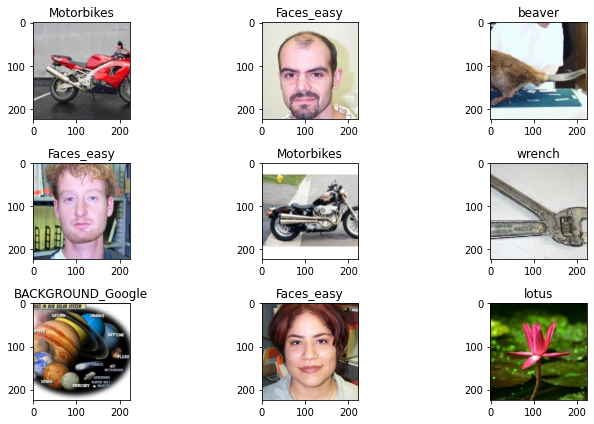

In [6]:
## Show sample data
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [0]:
learn = cnn_learner(data, models.resnet101,pretrained=True,metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


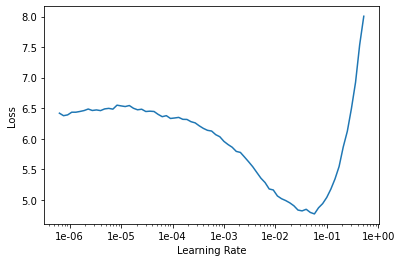

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.559928,3.564207,0.414661,02:10
1,1.677415,1.264210,0.673961,02:10
2,0.974083,0.632195,0.821663,02:10
3,0.574429,0.357404,0.894420,02:10
4,0.312435,0.280472,0.924508,02:10


In [0]:
learn.save('stg1-rn34')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


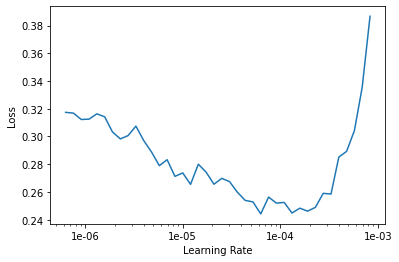

In [11]:
## Unfreeing layer and finding ideal learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.329249,0.312117,0.909190,02:58
1,0.359676,0.316841,0.909737,02:58
2,0.271106,0.254013,0.923414,02:58
3,0.152593,0.218876,0.931619,02:58
4,0.119171,0.215369,0.933260,02:58


In [0]:
## Saving model weights
learn.save('stg2-rn34')

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

In [15]:
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [0]:
import csv

img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features)) ## salvestada tekstifaili


In [0]:
pickle.dump(feature_dict, open('101_ObjectCategories/feature_dict.p', 'wb'))

In [0]:
feature_dict = pickle.load(open('101_ObjectCategories/feature_dict.p','rb'))
w = csv.writer(open("resnet101.csv", "w"))
for key, val in feature_dict.items():
    w.writerow([key, val])

In [19]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = lshash.LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [0]:
pickle.dump(lsh, open('101_ObjectCategories/lsh.p', "wb"))

In [0]:
from PIL import Image 

feature_dict = pickle.load(open('101_ObjectCategories/feature_dict.p','rb'))
lsh = pickle.load(open('101_ObjectCategories/lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

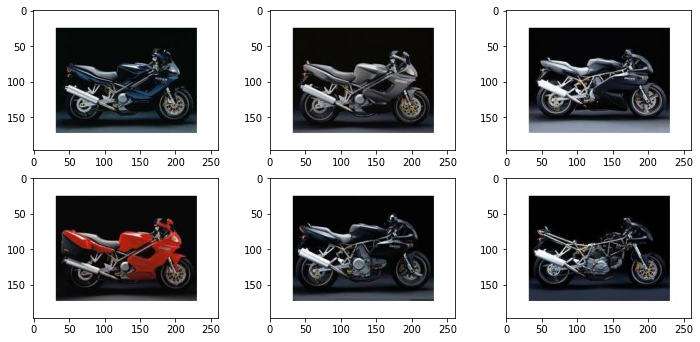

In [22]:
get_similar_item(9, feature_dict, lsh,5)

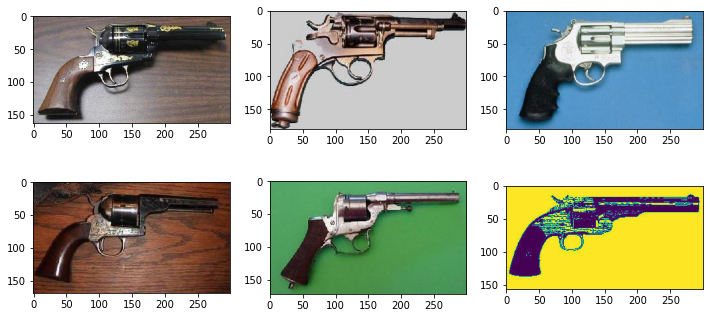

In [23]:
get_similar_item(1990, feature_dict, lsh,5)

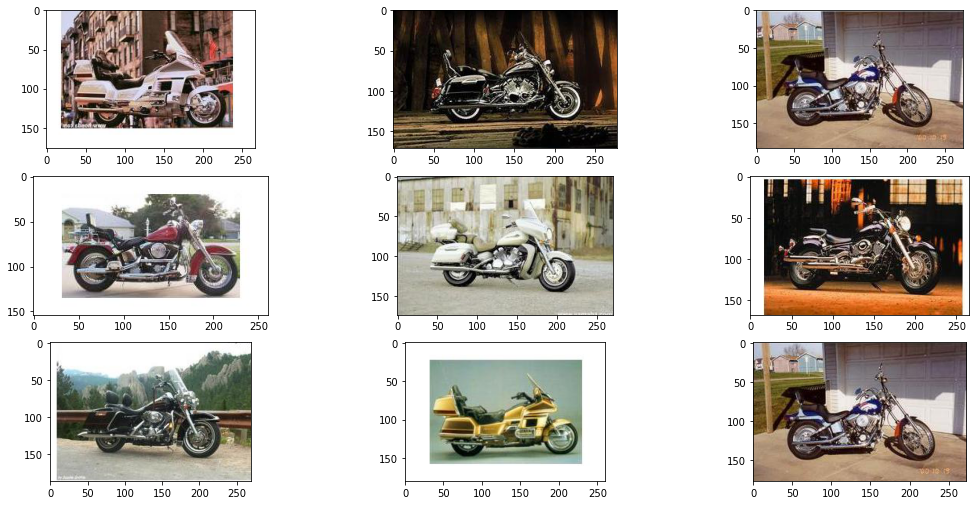

elapsed: 1.3005158159999155


In [24]:
import time
t = time.process_time()
get_similar_item(88, feature_dict, lsh, 8)
print("elapsed:", time.process_time()-t)